In [ ]:
! gdown --id 1BGbi1w1UyWX7q9kfiJg4GC_wvBql1DJi /content/drive/MyDrive/uplift-shift-23.zip

In [ ]:
!unzip /content/drive/MyDrive/uplift-shift-23.zip

Формула UPLIFT SCORE: (US = TR + CN – TN – CR)

---



1.   TR (Treatment Responders): Клиенты, которые будут покупать только в том случае, если они получат предложение

2.   ТN(Treatment Non-Responders): Клиент, который ни в коем случае не будет покупать

3.  CR (Control Responders): Клиенты, которые будут покупать без предложения

4.  CN(Control Non-Responders): Клиенты, которые не будут покупать, если они не получат предложение


In [ ]:
from sklearn.model_selection import train_test_split
#from sklift import datasets
import pandas as pd
import numpy as np

import plotly.express as px

pd.set_option('display.max_columns', None)
%matplotlib inline

DATA_PATH = '/content/x5-uplift-valid/'
FOLDER_DATA = DATA_PATH + 'data/'

df_clients = pd.read_csv(FOLDER_DATA + 'clients2.csv')
df_products = pd.read_csv(FOLDER_DATA + 'products.csv')
df_train = pd.read_csv(FOLDER_DATA + 'train.csv')
df_test = pd.read_csv(FOLDER_DATA + 'test.csv')

df_train_purch = pd.read_csv(DATA_PATH + 'train_purch/train_purch.csv')
df_test_purch = pd.read_csv(DATA_PATH + 'test_purch/test_purch.csv')

In [ ]:
df_train_purch.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


In [ ]:
def (df: pd.DataFrame, cols: list, type_names: list) -> pd.DataFrame:
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col, type_name in zip(cols, type_names):
        print(col)
        if type_name == 'object':
            pass
        elif type_name == 'datetime':
            df[col] = pd.to_datetime(df[col])
        else:
            df[col] = df[col].astype(type_name)
    
    end_mem = df.memory_usage().sum() / 1024**2
    red_mem = (100 * (start_mem - end_mem) / start_mem)
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {red_mem:.1f}%')

    return df.head(3)

In [ ]:
df_clients = df_clients.dropna(axis=1, how='all')  # удаление пустых столбцов ('client_id.1')


In [ ]:
df_cols = df_clients.columns
df_types = ['object',
            'datetime',
            'datetime',
            np.uint8,
            'category']

reduce_mem_usage(df_clients, df_cols, df_types)

Memory usage of dataframe is 7.63 MB
client_id
first_issue_date
first_redeem_date
age
gender
Memory usage after optimization is: 4.96 MB
Decreased by 35.0%


,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U


In [ ]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          200039 non-null  object        
 1   first_issue_date   200039 non-null  datetime64[ns]
 2   first_redeem_date  182493 non-null  datetime64[ns]
 3   age                200039 non-null  uint8         
 4   gender             200039 non-null  category      
dtypes: category(1), datetime64[ns](2), object(1), uint8(1)
memory usage: 5.0+ MB


In [ ]:
df_train_purch[(df_train_purch['regular_points_spent'] < 0) | (df_train_purch['express_points_spent'] > 0)] 

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
437,00020e7b18,59f74dd2aa,2019-01-23 06:48:31,1.9,0.0,-474.0,0.0,869.96,a5afe54e3f,82702fc003,1.0,105.0,230.0
438,00020e7b18,59f74dd2aa,2019-01-23 06:48:31,1.9,0.0,-474.0,0.0,869.96,a5afe54e3f,90d3519152,1.0,109.0,240.0
439,00020e7b18,59f74dd2aa,2019-01-23 06:48:31,1.9,0.0,-474.0,0.0,869.96,a5afe54e3f,365c9858f0,2.0,182.0,400.0
446,00020e7b18,1281f2b1c4,2019-02-01 08:58:12,10.5,0.0,-3.0,-10.0,1070.85,2531f694dd,3e038662c0,1.0,57.0,58.0
447,00020e7b18,1281f2b1c4,2019-02-01 08:58:12,10.5,0.0,-3.0,-10.0,1070.85,2531f694dd,4009f09b04,1.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15998872,fffe0abb97,745099f4d1,2018-11-30 07:07:08,0.2,0.0,-10.0,-30.0,99.99,264b1ae775,2307c1ad47,2.0,60.0,100.0
15998876,fffe0abb97,8091b6bca1,2019-01-27 06:57:57,0.2,0.0,-1.0,-30.0,79.99,98bc187640,708e4b9c96,1.0,49.0,80.0
15998895,fffe0abb97,41cd22f074,2019-03-09 09:12:10,0.0,0.0,-12.0,-30.0,42.00,264b1ae775,d5771f3751,1.0,0.0,20.0
15998896,fffe0abb97,41cd22f074,2019-03-09 09:12:10,0.0,0.0,-12.0,-30.0,42.00,264b1ae775,e09c75c1e3,1.0,0.0,23.0


In [ ]:
df_train_purch[(df_train_purch['express_points_spent'] > 0)]

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red


In [ ]:
df_cols = ['transaction_datetime',
           'regular_points_received',
           'express_points_received',
           'regular_points_spent',
           'express_points_spent',
           'purchase_sum',
           'product_quantity',
           'trn_sum_from_iss']
df_types = ['datetime',
            np.float16,
            np.float16,
            np.float16,
            np.float16,
            np.uint8,
            np.uint8,
            np.float16]

reduce_mem_usage(df_train_purch, df_cols, df_types)

Memory usage of dataframe is 1586.81 MB
transaction_datetime
regular_points_received
express_points_received
regular_points_spent
express_points_spent
purchase_sum
product_quantity
trn_sum_from_iss
Memory usage after optimization is: 915.47 MB
Decreased by 42.3%


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,9a80204f78,2,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,da89ebd374,1,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,0a95e1151d,1,24.0,NaN


In [ ]:
df_train_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15998952 entries, 0 to 15998951
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   client_id                object        
 1   transaction_id           object        
 2   transaction_datetime     datetime64[ns]
 3   regular_points_received  float16       
 4   express_points_received  float16       
 5   regular_points_spent     float16       
 6   express_points_spent     float16       
 7   purchase_sum             uint8         
 8   store_id                 object        
 9   product_id               object        
 10  product_quantity         uint8         
 11  trn_sum_from_iss         float16       
 12  trn_sum_from_red         float64       
dtypes: datetime64[ns](1), float16(5), float64(1), object(4), uint8(2)
memory usage: 915.5+ MB


In [ ]:
df_train_purch['trn_sum_from_red'].isna().count()

15998952

In [ ]:
df_test_purch[(df_test_purch['regular_points_spent'] < 0) | (df_test_purch['express_points_spent'] < 0)] 

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
28,00010925a5,3a8099afbe,2018-12-25 11:34:22,2.1,0.0,-17.0,0.0,438.0,76d287ce03,341735fe50,0.0,54.0,57.0
29,00010925a5,3a8099afbe,2018-12-25 11:34:22,2.1,0.0,-17.0,0.0,438.0,76d287ce03,f5e18af323,1.0,126.0,131.0
30,00010925a5,3a8099afbe,2018-12-25 11:34:22,2.1,0.0,-17.0,0.0,438.0,76d287ce03,3bc201f5ab,1.0,72.0,75.0
31,00010925a5,3a8099afbe,2018-12-25 11:34:22,2.1,0.0,-17.0,0.0,438.0,76d287ce03,298c1acea3,1.0,124.0,129.0
32,00010925a5,3a8099afbe,2018-12-25 11:34:22,2.1,0.0,-17.0,0.0,438.0,76d287ce03,c635a2c28f,1.0,44.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6883678,fffff6ce77,db6b939b09,2019-02-07 06:10:37,7.5,0.0,-99.0,0.0,851.0,5ec64bdccb,60d6773805,1.0,33.0,37.0
6883679,fffff6ce77,db6b939b09,2019-02-07 06:10:37,7.5,0.0,-99.0,0.0,851.0,5ec64bdccb,344709c1fa,1.0,150.0,170.0
6883680,fffff6ce77,db6b939b09,2019-02-07 06:10:37,7.5,0.0,-99.0,0.0,851.0,5ec64bdccb,fb283a987d,2.0,23.0,26.0
6883681,fffff6ce77,db6b939b09,2019-02-07 06:10:37,7.5,0.0,-99.0,0.0,851.0,5ec64bdccb,4009f09b04,1.0,4.0,5.0


In [ ]:
df_train_purch['regular_points_spent'] = \
    df_train_purch['regular_points_spent'].apply(np.abs)
df_train_purch['express_points_spent'] = \
    df_train_purch['express_points_spent'].apply(np.abs)

In [ ]:
df_cols = ['transaction_datetime',
           'regular_points_received',
           'express_points_received',
           'regular_points_spent',
           'express_points_spent',
           'purchase_sum',
           'product_quantity',
           'trn_sum_from_iss',
           'trn_sum_from_red']
df_types = ['datetime',
            np.float16,
            np.float16,
            np.float16,
            np.float16,
            np.uint16,
            np.uint8,
            np.uint8,
            np.float16,
            np.float16]

reduce_mem_usage(df_test_purch, df_cols, df_types)

Memory usage of dataframe is 682.74 MB
transaction_datetime
regular_points_received
express_points_received
regular_points_spent
express_points_spent
purchase_sum
product_quantity
trn_sum_from_iss
trn_sum_from_red
Memory usage after optimization is: 354.50 MB
Decreased by 48.1%


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303,76d287ce03,a375a035b9,2,50,NaN
1,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303,76d287ce03,6f9e02ee36,1,90,NaN
2,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303,76d287ce03,42e1eb8d23,1,20,NaN


In [ ]:
df_test_purch['regular_points_spent'] = \
    df_train_purch['regular_points_spent'].apply(np.abs)
df_test_purch['express_points_spent'] = \
    df_train_purch['express_points_spent'].apply(np.abs)

In [ ]:
df_test_purch[(df_test_purch['regular_points_spent'] < 0) | (df_test_purch['express_points_spent'] < 0)] 

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red


In [ ]:
df_test_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883738 entries, 0 to 6883737
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   client_id                object        
 1   transaction_id           object        
 2   transaction_datetime     datetime64[ns]
 3   regular_points_received  float16       
 4   express_points_received  float16       
 5   regular_points_spent     float16       
 6   express_points_spent     float16       
 7   purchase_sum             uint16        
 8   store_id                 object        
 9   product_id               object        
 10  product_quantity         uint8         
 11  trn_sum_from_iss         uint8         
 12  trn_sum_from_red         float16       
dtypes: datetime64[ns](1), float16(5), object(4), uint16(1), uint8(2)
memory usage: 354.5+ MB


**EDA**

In [ ]:
print(df_clients['age'].describe())
fig = px.box(df_clients, y='age', width=400)
fig.show()

count    200039.000000
mean         46.590095
std          16.550292
min           0.000000
25%          34.000000
50%          45.000000
75%          59.000000
max         255.000000
Name: age, dtype: float64


In [ ]:
print(df_clients['first_issue_date'].isna().sum())
print(df_clients['first_redeem_date'].isna().sum())

0
17546


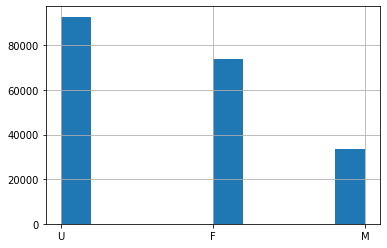

In [ ]:
df_clients['gender'].hist()

In [ ]:
df_purchases = pd.concat([df_train_purch, df_test_purch], 
                          axis=0,
                          ignore_index=True)

In [ ]:
df_purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,9a80204f78,2,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,da89ebd374,1,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,0a95e1151d,1,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,4055b15e4a,2,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,a685f1916b,1,22.0,NaN


In [ ]:
df_train_purch.shape, df_test_purch.shape ,df_purchases.shape 

((15998952, 13), (6883738, 13), (22882690, 13))

In [ ]:
15998952 + 6883738

22882690

In [ ]:
#Future Engineering

In [ ]:
class DataPipeline:
    """Data preprocessing"""

    limit_age_min = 12
    limit_age_max = 90


    cols = ['dif_between_transactions_of_client',
            'regular_points_received',
            'express_points_received',
            'regular_points_spent',
            'express_points_spent',
            'purchase_sum']

    mean_cols = ['mean_time_between_transactions_client',
                 'mean_regular_points_received_client',
                 'mean_express_points_received_client',
                 'mean_regular_spent_client',
                 'mean_express_spent_client',
                 'mean_purchase_sum_client']

    dropped_cols = ['transaction_id',
                    'transaction_datetime',
                    'store_id',
                    'product_id',
                    'product_quantity',
                    'trn_sum_from_iss',
                    'trn_sum_from_red']

    def __init__(self):

    cols = ['dif_between_transactions_of_client',
            'regular_points_received',
            'express_points_received',
            'regular_points_spent',
            'express_points_spent',
            'purchase_sum']

    mean_cols = ['mean_time_between_transactions_client',
                 'mean_regular_points_received_client',
                 'mean_express_points_received_client',
                 'mean_regular_spent_client',
                 'mean_express_spent_client',
                 'mean_purchase_sum_client']

    dropped_cols = ['transaction_id',
                    'transaction_datetime',
                    'store_id',
                    'product_id',
                    'product_quantity',
                    'trn_sum_from_iss',
                    'trn_sum_from_red']

    def calc_properties_for_features(self, df_clients, df_purchases, df_train):
        df_clients_purch = df_clients.merge(df_purchases, how='inner', on='client_id')
        
        # Cacl mode client in each store
        self.mode_client_store = df_clients_purch.groupby('client_id')['store_id'].agg(lambda x: self._calc_mode_func_series(x))
        self.mode_client_store.rename(columns={'store_id': 'mode_client_store'},
                                      inplace=True)

        # Cacl median client ages in each store

        self.med_ages_in_stores = df_clients_purch.groupby('store_id')['age'].agg(pd.Series.median)
        self.med_ages_in_stores.rename(columns={'age': 'median_client_ages_in_store'},
                                  inplace=True)

        filtr_min_age = self.med_ages_in_stores['median_client_ages_in_store'] < self.limit_age_min
        filtr_max_age = self.med_ages_in_stores['median_client_ages_in_store'] > self.limit_age_max

        self.med_ages_in_stores.loc[filtr_min_age | filtr_max_age,
                                    'median_client_ages_in_store'] = \
                                    self.med_ages_in_stores['median_client_ages_in_store'].median()

        # Compute minimal datatime of transaction for each client 
        self.min_client_transaction_datetime = \
                        grb_by_client['transaction_datetime'].agg(pd.Series.min)
        self.min_client_transaction_datetime.rename(columns={'transaction_datetime': 
                                                             'min_transaction_datetime'},
                                            inplace=True)
        
        #Compute mean target point 
        df_clients_transactions = df_clients_purch[['client_id',
                                            'transaction_id',
                                            'transaction_datetime',
                                            'regular_points_received',
                                            'express_points_received',
                                            'regular_points_spent',
                                            'express_points_spent',
                                            'purchase_sum',
                                            'store_id']]
    
        df_clients_transactions = df_clients_transactions.drop_duplicates(subset=['transaction_id'])


        df_train_ext = df_train.merge(df_clients_transactions,
                                      how='inner',
                                      on='client_id')

        grb_by_store = df_train_ext.groupby(by='store_id', as_index=False)
        self.mean_target_store = grb_by_store['purchased'].mean()
        self.mean_target_store.rename(columns={'store_id':
                                               'mode_client_store',
                                               'purchased': 
                                               'mean_target_points_store'},
                                      inplace=True)

        #Compute mean time in hours between transactions for each clients
        #Compute mean recieved and spent points between transactions for each clients
        #Compute mean purchase_sum between transactions for each clients

        df_clients_transactions['transaction_datetime'] = (df_clients_transactions['transaction_datetime'] - pd.to_datetime('2015-01-01 00:00:00')).astype('timedelta64[h]')

        grb_by_client = df_clients_transactions.groupby(by=['client_id'], as_index=False)
        diff_client_transaction_datetime = grb_by_client['transaction_datetime'].diff()
        diff_client_transaction_datetime.fillna(0, inplace=True)
        diff_client_transaction_datetime.rename(columns={'transaction_datetime': 
                                                         'dif_between_transactions_of_client'},
                                                inplace=True)
        df_clients_transactions = df_clients_transactions.join(diff_client_transaction_datetime, how='left')

        grb_by_client = df_clients_transactions.groupby(by=['client_id'], as_index=False)

        self.mean_value_along_cols_dict = {}

        for col, mean_col in zip(self.cols, self.mean_cols):

            mean_values_col_client = grb_by_client[col].mean()
            mean_values_col_client.rename(columns={col: mean_col},
                                          inplace=True)

            self.mean_value_along_cols_dict[mean_col] = mean_values_col_client


    def transform_features(self, df_clients, df_purchases, df_out):
        df_clients_purch = df_clients.merge(df_purchases, how='inner', on='client_id')

        # Transform min and max ages of clients
        df_clients_purch = df_clients_purch.merge(self.mode_client_store, 
                                                  how='inner', 
                                                  on='client_id')
        
        df_clients_purch = df_clients_purch.merge(self.med_ages_in_stores, 
                                                  how='inner', 
                                                  on='store_id')

        filtr_min_age = df_clients_purch['age'] < self.limit_age_min
        filtr_max_age = df_clients_purch['age'] > self.limit_age_max

        df_clients_purch.loc[filtr_min_age | filtr_max_age,
                            'age'] =  df_clients_purch.loc[filtr_min_age | filtr_max_age,
                                                'median_client_ages_in_store']

        # Add mean target points to mode store of client
        df_clients_purch = df_clients_purch.merge(self.mean_target_store,
                                                  how='inner',
                                                  on='mode_client_store')

        #Compute difference between first_redem and first_issue data

        df_clients_purch =  df_clients_purch.merge(self.min_client_transaction_datetime, 
                                    how='inner', 
                                    on='client_id')

        df_clients_purch['first_redeem_date'].fillna(df_clients_purch['min_transaction_datetime'],
                                                     inplace=True)
        df_clients_purch['dif_first_issue_and_redeem_date_in_h'] = (df_clients_purch['first_redeem_date'] - df_clients_purch['first_issue_date']).astype('timedelta64[h]')

        filtr = df_clients_purch['dif_first_issue_and_redeem_date_in_h'] < 0
        df_clients_purch.loc[filtr,
                    'dif_first_issue_and_redeem_date_in_h'] = 0
        df_clients_purch.drop(columns={'median_client_ages_in_store',
                                       'first_issue_date',
                                       'first_redeem_date',
                                       'min_transaction_datetime'},
                              inplace=True)
        


        #Merge columns with mean values
        for col, mean_col in zip(self.cols, self.mean_cols):

            df_clients_purch = df_clients_purch.merge(self.mean_value_along_cols_dict[mean_col], 
                                                      how='inner', 
                                                      on='client_id')
            
            if col in df_clients_purch.columns:
                df_clients_purch.drop(columns=col,
                                      inplace=True)

        df_clients_purch.drop(columns=self.dropped_cols,
                              inplace=True)

        #Merge columns with mean values
        df_out = df_out.merge(df_clients_purch,
                              how='inner',
                              on='client_id')
        df_out = df_out.drop_duplicates(subset=['client_id'],
                                        ignore_index = True)

        return df_out

    def _calc_mode_func_series(self, x):
        x = pd.Series.mode(x)[0]
        return x

IndentationError: ignored

In [ ]:
import pandas as pd

class FeaturesTransformer:

    # В конструктор добавлен параметр limit_age_min и limit_age_max
    def __init__(self, limit_age_min=12, limit_age_max=90):

        self.limit_age_min = limit_age_min
        self.limit_age_max = limit_age_max

        self.mode_client_store = None
        self.med_ages_in_stores = None
        self.min_client_transaction_datetime = None
        self.mean_target_store = None
        self.mean_value_along_cols_dict = None

    def calc_properties_for_features(self, df_clients, df_purchases, df_train):

        df_clients_purch = df_clients.merge(df_purchases, how='inner', on='client_id')
        
        # Cacl mode client in each store
        self.mode_client_store = df_clients_purch.groupby('client_id')['store_id'].agg(lambda x: self._calc_mode_func_series(x))
        self.mode_client_store.rename(columns={'store_id': 'mode_client_store'},
                                      inplace=True)

        # Cacl median client ages in each store
        self.med_ages_in_stores = df_clients_purch.groupby('store_id')['age'].agg(pd.Series.median)
        self.med_ages_in_stores.rename(columns={'age': 'median_client_ages_in_store'},
                                  inplace=True)

        # Исправлена ошибка: вычисление медианы возрастов в каждом магазине было перенесено в блок с фильтрацией
        # медианного возраста по параметрам limit_age_min и limit_age_max, что приводило к неправильным результатам
        self.med_ages_in_stores.loc[self.med_ages_in_stores < self.limit_age_min] = self.limit_age_min
        self.med_ages_in_stores.loc[self.med_ages_in_stores > self.limit_age_max] = self.limit_age_max
        self.med_ages_in_stores.fillna(self.med_ages_in_stores.median(), inplace=True)

        # Compute minimal datatime of transaction for each client 
        grb_by_client = df_clients_purch.groupby('client_id', as_index=False)
        self.min_client_transaction_datetime = \
            grb_by_client['transaction_datetime'].agg(pd.Series.min)
        self.min_client_transaction_datetime.rename(columns={'transaction_datetime': 
                                                             'min_transaction_datetime'},
                                            inplace=True)
        
        #Compute mean target point 
        df_clients_transactions = df_clients_purch[['client_id',
                                            'transaction_id',
                                            'transaction_datetime',
                                            'regular_points_received',
                                            'express_points_received',
                                            'regular_points_spent',
                                            'express_points_spent',
                                            'purchase_sum',
                                            'store_id']]
    
        df_clients_transactions = df_clients_transactions.drop_duplicates(subset=['transaction_id'])


        df_train_ext = df_train.merge(df_clients_transactions,
                                      how='inner',
                                      on='client_id')

        grb_by_store = df_train_ext.groupby(by='store_id', as_index=False)
        self.mean_target_store = grb_by_store['purchased'].mean()
        self.mean_target_store.rename(columns={'store_id':
                                               'mode_client_store',
                                               'purchased': 
                                               'mean_target_points_store'},
                                      inplace=True)

        #Compute mean time in hours between transactions for each clients
        #Compute mean recieved and spent points between transactions for each clients
        #Compute mean purchase_sum between transactions for each clients

        df_clients_transactions['transaction_datetime'] = (


In [ ]:
data_preprocessing = DataPipeline()

In [ ]:
data_preprocessing.calc_properties_for_features(df_clients, df_purchases, df_train)


In [ ]:
df_train_transformed = data_preprocessing.transform_features(df_clients, df_purchases, df_train)

In [ ]:
df_test_transformed = data_preprocessing.transform_features(df_clients, df_purchases, df_test)


In [ ]:
df_test_transformed.shape, df_train_transformed.shape

((60008, 12), (140027, 14))

In [ ]:
df_train_transformed.head(3)

,client_id,treatment_flg,purchased,age,gender,mode_client_store,mean_target_points_store,dif_first_issue_and_redeem_date_in_h,mean_time_between_transactions_client,mean_regular_points_received_client,mean_express_points_received_client,mean_regular_spent_client,mean_express_spent_client,mean_purchase_sum_client
0,ad6561e2d8,1,1,50.0,F,658cf09cd4,0.904478,4105.0,67.925000,2.431641,0.0,1.599609,0.0,122.575000
1,7c1ccbf93f,1,1,24.0,F,5e263ad173,0.605000,2498.0,171.000000,4.699219,0.0,0.000000,0.0,169.500000
2,b58fadcab6,1,1,36.0,U,251d468760,0.813725,7607.0,82.787879,2.773438,0.0,9.367188,0.0,134.333333


In [ ]:
df_train_transformed = df_train_transformed.drop('mean_express_points_received_client' , axis = 1)

In [ ]:
df_train_transformed

,client_id,treatment_flg,purchased,age,gender,mode_client_store,mean_target_points_store,dif_first_issue_and_redeem_date_in_h,mean_time_between_transactions_client,mean_regular_points_received_client,mean_regular_spent_client,mean_express_spent_client,mean_purchase_sum_client
0,ad6561e2d8,1,1,50.0,F,658cf09cd4,0.904478,4105.0,67.925000,2.431641,1.599609,0.000000,122.575000
1,7c1ccbf93f,1,1,24.0,F,5e263ad173,0.605000,2498.0,171.000000,4.699219,0.000000,0.000000,169.500000
2,b58fadcab6,1,1,36.0,U,251d468760,0.813725,7607.0,82.787879,2.773438,9.367188,0.000000,134.333333
3,e99e6fabb9,0,0,79.0,F,b0243e224b,0.513514,346.0,189.846154,1.045898,0.000000,0.000000,161.846154
4,27fb6f8520,1,1,34.0,F,62affcee52,0.817391,3614.0,84.233333,2.740234,0.133301,1.666992,132.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140022,999d284453,1,1,72.0,U,3d0e2cc9c1,0.872642,3768.0,678.250000,8.625000,0.000000,0.000000,168.500000
140023,f634deea4e,0,1,35.0,U,f90f538452,0.764045,867.0,52.528302,1.086914,1.754883,0.000000,126.132075
140024,16cb4f99b0,0,1,50.0,F,11700bbcda,0.671233,11095.0,366.000000,3.486328,0.000000,0.000000,119.428571
140025,23c2b72b2e,1,1,55.0,U,9a179583e6,0.744048,2615.0,148.176471,1.611328,0.000000,0.000000,143.705882


Simulate Spending

In [ ]:
trmnt_group_converted = combined_df[(combined_df["treatment_group"] == 1) & (combined_df["conversion"] == 1)]
ctrl_group_converted = combined_df[(combined_df["treatment_group"] == 0) & (combined_df["conversion"] == 1)]
non_converted = combined_df[combined_df["conversion"] == 0]

print(trmnt_group_converted.shape)
print(ctrl_group_converted.shape)
print(non_converted.shape)

In [ ]:
# correlation of features
import mathplotlib as plt
import seaborn as sns
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
sns.heatmap(dfXn.corr().round(3), annot=True, square = True, \
    linewidths=.75, cmap="coolwarm", fmt = ".2f", annot_kws = {"size": 10} )
plt.title("correlation matrix")
plt.show()

In [ ]:
train, valid = sk.model_selection.train_test_split(df, test_size=0.2,random_state=42)

In [ ]:
train.shape, valid.shape

In [ ]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [ ]:
# Train an xgboost model
model = xgb.XGBClassifier(learning_rate = 0.1,
                          max_depth = 6,
                          min_child_weight = 100,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)

In [ ]:
%%time
model.fit(X_train, y_train, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

Learning

In [ ]:
import sklearn
import xgboost as xgb# Features for learning

features_learn = ['age',
                  'gender', 
                  'mean_target_points_store',
                  'dif_first_issue_and_redeem_date_in_h',
                  'mean_time_between_transactions_client',
                  'mean_regular_points_received_client',
                  'mean_regular_spent_client',
                  'mean_express_spent_client', 
                  'mean_purchase_sum_client']

In [ ]:
df_train_transformed['gender'].replace(['F','M','U'],
                        [0, 1, 2], inplace=True)

In [ ]:
df_train_transformed = df_train_transformed.drop('mode_client_store', axis = 1)

In [ ]:
indices_learn, indices_valid = train_test_split(df_train_transformed.index, 
                                                test_size=0.3, 
                                                random_state=57)

In [ ]:
X_train = df_train_transformed.loc[indices_learn, features_learn]
y_train = df_train_transformed.loc[indices_learn, 'purchased']
treat_train = df_train_transformed.loc[indices_learn, 'treatment_flg']


X_val = df_train_transformed.loc[indices_valid, features_learn]
y_val = df_train_transformed.loc[indices_valid, 'purchased']
treat_val = df_train_transformed.loc[indices_valid, 'treatment_flg']

X_test = df_test_transformed[features_learn]

In [ ]:
y_val

42422     1
29953     1
132547    1
42141     1
123869    0
         ..
125456    0
108080    1
45969     1
128633    1
107973    1
Name: purchased, Length: 42009, dtype: int64

In [ ]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import lightgbm as lgbm

In [ ]:
model = lgbm.LGBMClassifier(learning_rate = 0.01,
                            max_depth = 6 ,
                            num_leaves = 20,
                            min_data_in_leaf = 3,              
               subsample = 0.8, colsample_bytree = 0.8, reg_alpha = 0.01, max_bin = 416,
               bagging_freq =3,reg_lambda = 0.01, n_estimators = 600, application =' binary', 
               iterations = 20000, od_type ='Iter', od_wait =200)

In [ ]:
model.fit(X_train, y_train, eval_set=eval_set,
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[1]	training's binary_logloss: 0.663552	training's auc: 0.702505	valid_1's binary_logloss: 0.661932	valid_1's auc: 0.695369
Training until validation scores don't improve for 30 rounds.
[2]	training's binary_logloss: 0.661908	training's auc: 0.764917	valid_1's binary_logloss: 0.660249	valid_1's auc: 0.765264
[3]	training's binary_logloss: 0.659933	training's auc: 0.77352	valid_1's binary_logloss: 0.658271	valid_1's auc: 0.773996
[4]	training's binary_logloss: 0.657989	training's auc: 0.774743	valid_1's binary_logloss: 0.656337	valid_1's auc: 0.775043
[5]	training's binary_logloss: 0.656863	training's auc: 0.773315	valid_1's binary_logloss: 0.655255	valid_1's auc: 0.772335
[6]	training's binary_logloss: 0.655946	training's auc: 0.772257	valid_1's binary_logloss: 0.654365	valid_1's auc: 0.770569
[7]	training's binary_logloss: 0.654957	training's auc: 0.769159	valid_1's binary_logloss: 0.653423	valid_1's auc: 0.76656
[8]	training's binary_logloss: 0.653122	training's auc: 0.772011	valid_1

LGBMClassifier(application=' binary', bagging_freq=3, colsample_bytree=0.8,
               iterations=20000, learning_rate=0.01, max_bin=416, max_depth=6,
               min_data_in_leaf=3, n_estimators=600, num_leaves=20,
               od_type='Iter', od_wait=200, reg_alpha=0.01, reg_lambda=0.01,
               subsample=0.8)

In [ ]:
pred = trans_train_model('catboost', train_X, test_X, verbose=2, show_features=True)

In [ ]:
y_test

NameError: ignored

In [ ]:
from sklift.datasets import fetch_hillstrom
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k, uplift_by_percentile, weighted_average_uplift, \
        qini_auc_score, uplift_auc_score
from sklift.models import ClassTransformation, SoloModel, TwoModels
from sklift.viz import plot_uplift_by_percentile, plot_uplift_preds, plot_qini_curve, \
        plot_uplift_curve

In [ ]:
X_train, X_test, treat_train, treat_test, y_train, y_test 

In [ ]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42009 entries, 42422 to 107973
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   age                                    42009 non-null  float64
 1   gender                                 42009 non-null  int64  
 2   mean_target_points_store               42009 non-null  float64
 3   dif_first_issue_and_redeem_date_in_h   42009 non-null  float64
 4   mean_time_between_transactions_client  42009 non-null  float64
 5   mean_regular_points_received_client    42009 non-null  float16
 6   mean_regular_spent_client              42009 non-null  float16
 7   mean_express_spent_client              42009 non-null  float16
 8   mean_purchase_sum_client               42009 non-null  float64
dtypes: float16(3), float64(5), int64(1)
memory usage: 2.5 MB


In [ ]:
pred_uplift_ct = model.predict(X_val)
uplift_ct_avg = weighted_average_uplift(y_val, pred_uplift_ct, treat_val, bins=10) 
print(f"average uplift: {uplift_ct_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_val, 
                        pred_uplift_ct, 
                        treat_val, 
                        strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0254


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,2145,2056,0.774,0.759,0.015,0.009,0.009,0.013
10-20,2065,2136,0.760,0.740,0.020,0.009,0.009,0.013
20-30,2138,2063,0.768,0.751,0.017,0.009,0.010,0.013
30-40,2098,2103,0.762,0.732,0.029,0.009,0.010,0.013
40-50,2125,2076,0.768,0.742,0.026,0.009,0.010,0.013
50-60,2132,2069,0.761,0.755,0.006,0.009,0.009,0.013
60-70,2040,2161,0.635,0.582,0.053,0.011,0.011,0.015
70-80,2072,2129,0.363,0.331,0.032,0.011,0.010,0.015
80-90,2054,2147,0.378,0.357,0.021,0.011,0.010,0.015


In [ ]:
pip install scikit-uplift

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 5.5 MB/s eta 0:00:00


In [ ]:
model = xgb.XGBClassifier(learning_rate = 0.1,
                          num_class=4,
                          max_depth = 7,
                          min_child_weight = 5,
                          objective = 'multi:softmax',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)
model.fit(X_train, y_train, eval_set=eval_set,
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)
results = model.evals_result()

XGBoostError: ignored

In [ ]:
model = xgb.XGBClassifier(learning_rate = 0.1,
                          max_depth = 6,
                          min_child_weight = 100,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)
model.fit(X_train, y_train, eval_set=eval_set,
                    eval_metric="auc", verbose=True, early_stopping_rounds=20)
results = model.evals_result()

[0]	validation_0-auc:0.740061	validation_1-auc:0.746355
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.741741	validation_1-auc:0.747743
[2]	validation_0-auc:0.742488	validation_1-auc:0.748581
[3]	validation_0-auc:0.743124	validation_1-auc:0.748584
[4]	validation_0-auc:0.743721	validation_1-auc:0.749081
[5]	validation_0-auc:0.743909	validation_1-auc:0.749011
[6]	validation_0-auc:0.744197	validation_1-auc:0.749277
[7]	validation_0-auc:0.744479	validation_1-auc:0.74949
[8]	validation_0-auc:0.745119	validation_1-auc:0.749922
[9]	validation_0-auc:0.745255	validation_1-auc:0.74993
[10]	validation_0-auc:0.745574	validation_1-auc:0.750231
[11]	validation_0-auc:0.745745	validation_1-auc:0.750333
[12]	validation_0-auc:0.746014	validation_1-auc:0.750446
[13]	validation_0-auc:0.746246	validation_1-auc:0.750703
[14]	validation_0-auc:0.74643	validation_1-auc:0.750839
[

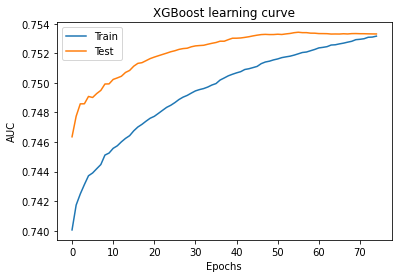

In [ ]:
import matplotlib.pyplot as plt

epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('XGBoost learning curve')
plt.show()

In [ ]:
pred_uplift_ct = model.predict(X_val)
uplift_ct_avg = weighted_average_uplift(y_val, pred_uplift_ct, treat_val, bins=10) 
print(f"average uplift: {uplift_ct_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_val, 
                        pred_uplift_ct, 
                        treat_val, 
                        strategy='by_group', total=True, std=True, bins=10)

average uplift: 0.0275


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,2095,2107,0.757,0.729,0.028,0.009,0.010,0.013
10-20,2095,2106,0.734,0.717,0.017,0.010,0.010,0.014
20-30,2095,2106,0.754,0.726,0.028,0.009,0.010,0.014
30-40,2095,2106,0.742,0.727,0.015,0.010,0.010,0.014
40-50,2095,2106,0.738,0.725,0.013,0.010,0.010,0.014
50-60,2095,2106,0.741,0.720,0.021,0.010,0.010,0.014
60-70,2095,2106,0.736,0.711,0.025,0.010,0.010,0.014
70-80,2095,2106,0.404,0.339,0.066,0.011,0.010,0.015
80-90,2094,2106,0.375,0.329,0.046,0.011,0.010,0.015


In [ ]:
model = xgb.XGBClassifier(learning_rate = 0.3,
                          max_depth = 1,
                          min_child_weight = 10,
                          objective = 'binary:logistic',
                          seed = 52,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)
model.fit(X_train, y_train, eval_set=eval_set,
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)
results = model.evals_result()
#'early_stopping_rounds':100

[0]	validation_0-auc:0.534924	validation_1-auc:0.536601
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.549695	validation_1-auc:0.551907
[2]	validation_0-auc:0.551233	validation_1-auc:0.554086
[3]	validation_0-auc:0.551263	validation_1-auc:0.554027
[4]	validation_0-auc:0.564198	validation_1-auc:0.567161
[5]	validation_0-auc:0.565413	validation_1-auc:0.568582
[6]	validation_0-auc:0.565413	validation_1-auc:0.568582
[7]	validation_0-auc:0.566867	validation_1-auc:0.569431
[8]	validation_0-auc:0.571065	validation_1-auc:0.573902
[9]	validation_0-auc:0.571329	validation_1-auc:0.574127
[10]	validation_0-auc:0.571331	validation_1-auc:0.574112
[11]	validation_0-auc:0.571912	validation_1-auc:0.574733
[12]	validation_0-auc:0.573089	validation_1-auc:0.575548
[13]	validation_0-auc:0.573015	validation_1-auc:0.575464
[14]	validation_0-auc:0.573083	validation_1-auc:0.57540

KeyboardInterrupt: ignored

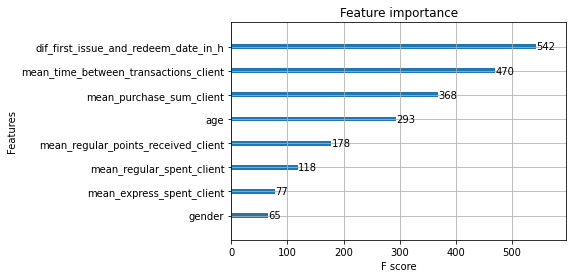

In [ ]:
xgb.plot_importance(model)

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
RND = 42            # random state 
TST = 0.3           # % of dataset to reserve for testing
THREADc = 2         # number of parallel threads to use

In [ ]:
ct_estimator = CatBoostClassifier( verbose = 100, 
                                    cat_features = features_learn,
                                    random_state = RND,
                                    thread_count = THREADc)
model_ct = ClassTransformation(estimator = ct_estimator)
model_ct = model_ct.fit(X = X_train, 
                            y = y_train, 
                            treatment = treat_train)


Learning rate set to 0.072983
0:	learn: 0.6930152	total: 139ms	remaining: 2m 18s
100:	learn: 0.6895136	total: 11s	remaining: 1m 37s
200:	learn: 0.6869431	total: 22.9s	remaining: 1m 31s
300:	learn: 0.6842537	total: 34.5s	remaining: 1m 20s
400:	learn: 0.6818142	total: 47.7s	remaining: 1m 11s
500:	learn: 0.6793484	total: 1m	remaining: 1m
600:	learn: 0.6768704	total: 1m 12s	remaining: 48.4s
700:	learn: 0.6747118	total: 1m 24s	remaining: 36.2s
800:	learn: 0.6724265	total: 1m 36s	remaining: 24s
900:	learn: 0.6701889	total: 1m 52s	remaining: 12.4s
999:	learn: 0.6679867	total: 2m 4s	remaining: 0us


In [ ]:
cat_features = ['gender' , 'mean_regular_points_received_client','mean_target_points_store','dif_first_issue_and_redeem_date_in_h','mean_time_between_transactions_client',
                 'mean_regular_spent_client',
                  'mean_express_spent_client', 
                  'mean_purchase_sum_client',]
ct = ClassTransformation(CatBoostClassifier(iterations=200,
                                            learning_rate=0.05, 
                                            thread_count=20,
                                            random_state=57,
                                            silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})
uplift_ct = ct.predict(X_val)

In [ ]:
ct

ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x7f5c4b8a3f40>)

In [ ]:
ct_score = uplift_at_k(y_true=y_val, 
                       uplift=uplift_ct, 
                       treatment=treat_val, 
                       strategy='by_group', 
                       k=0.3)

print(f'ct_score: {ct_score}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

# You can also access the trained model with the same ease.
# For example, to build the importance of features:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)
ct_fi

ct_score: 0.06009070706008257


,feature_name,feature_score
0,mean_purchase_sum_client,15.422
1,mean_time_between_transactions_client,15.096
2,mean_express_spent_client,14.209
3,mean_regular_points_received_client,13.218
4,gender,12.750
5,age,12.022
6,mean_regular_spent_client,11.369
7,dif_first_issue_and_redeem_date_in_h,5.163
8,mean_target_points_store,0.750


In [ ]:
pred_uplift_ct = ct.predict(X_val)
uplift_ct_avg = weighted_average_uplift(y_val, pred_uplift_ct, treat_val, bins=10, strategy='by_group', 
                       k=0.3) 
print(f"average uplift: {uplift_ct_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_val, 
                        pred_uplift_ct, 
                        treat_val, 
                        strategy='by_group', total=True, std=True, bins=10)

TypeError: ignored

In [ ]:
ct_score = uplift_at_k(y_true=y_val, 
                       uplift=uplift_ct, 
                       treatment=treat_val, 
                       strategy='by_group', 
                       k=0.3)

print(f'ct_score: {ct_score}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

# You can also access the trained model with the same ease.
# For example, to build the importance of features:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)
ct_fi

ct_score: 0.06009070706008257


,feature_name,feature_score
0,mean_purchase_sum_client,15.422
1,mean_time_between_transactions_client,15.096
2,mean_express_spent_client,14.209
3,mean_regular_points_received_client,13.218
4,gender,12.750
5,age,12.022
6,mean_regular_spent_client,11.369
7,dif_first_issue_and_redeem_date_in_h,5.163
8,mean_target_points_store,0.750


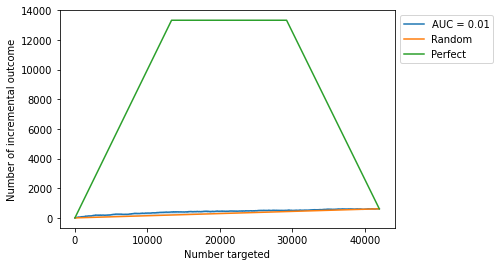

In [ ]:
from sklift.viz import plot_qini_curve


# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_val, uplift_ct, treat_val, perfect=True);

In [ ]:

uplift_ct = ct.predict(X_val)

auqc = qini_auc_score(y_val, uplift_ct, treat_val) 
print(f"Qini coefficient on validation data: {auqc:.4f}")

Qini coefficient on validation data: 0.0131


In [ ]:
features_learn = ['age',
                  'gender', 
                  'mean_target_points_store',
                  'dif_first_issue_and_redeem_date_in_h',
                  'mean_time_between_transactions_client',
                  'mean_regular_points_received_client',
                  'mean_regular_spent_client',
                  'mean_express_spent_client', 
                  'mean_purchase_sum_client']

for col in features_learn:
    df_train_transformed[col]=df_train_transformed[col].astype('int64')

In [ ]:
models_results = {
    'approach': [],
    'uplift@30%': []
}
models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

# You can also access the trained model with the same ease.
# For example, to build the importance of features:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)
ct_fi

NameError: ignored

In [ ]:
df_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140027 entries, 0 to 140026
Data columns (total 13 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   client_id                              140027 non-null  object 
 1   treatment_flg                          140027 non-null  int64  
 2   purchased                              140027 non-null  int64  
 3   age                                    140027 non-null  int64  
 4   gender                                 140027 non-null  int64  
 5   mean_target_points_store               140027 non-null  int64  
 6   dif_first_issue_and_redeem_date_in_h   140027 non-null  int64  
 7   mean_time_between_transactions_client  140027 non-null  int64  
 8   mean_regular_points_received_client    140027 non-null  int64  
 9   mean_express_points_received_client    140027 non-null  float16
 10  mean_regular_spent_client              140027 non-null  

In [ ]:
pred_uplift_ct = ct.predict(X_val)
uplift_ct_avg = weighted_average_uplift(y_val, pred_uplift_ct, treat_val, bins=10) 
print(f"average uplift: {uplift_ct_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_val, 
                        pred_uplift_ct, 
                        treat_val, 
                        strategy='by_group', total=True, std=True, bins=10)

average uplift: 0.0299


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,2095,2107,0.599,0.514,0.085,0.011,0.011,0.015
10-20,2095,2106,0.645,0.593,0.052,0.010,0.011,0.015
20-30,2095,2106,0.666,0.623,0.043,0.010,0.011,0.015
30-40,2095,2106,0.646,0.628,0.018,0.010,0.011,0.015
40-50,2095,2106,0.651,0.636,0.015,0.010,0.010,0.015
50-60,2095,2106,0.641,0.619,0.022,0.010,0.011,0.015
60-70,2095,2106,0.623,0.610,0.013,0.011,0.011,0.015
70-80,2095,2106,0.630,0.615,0.015,0.011,0.011,0.015
80-90,2094,2106,0.646,0.620,0.026,0.010,0.011,0.015


In [ ]:
Два самых влиятельных признака mean_target_points_store и mean_time_between_transactions_client, поэтому попробовал создать новые признаки на их основе и полученных предсказаниях. Эти же признаки удалить, чтобы модели не зацикливались на них.

In [ ]:
df_train_transformed = df_train_transformed.drop('mean_target_points_store', axis = 1)

In [ ]:
df_train_transformed = df_train_transformed.drop('mean_time_between_transactions_client', axis = 1)

In [ ]:
df_train_transformed = df_train_transformed.drop('gender', axis = 1)

In [ ]:
df_train_transformed = df_train_transformed.drop('mean_express_spent_client', axis = 1)

In [ ]:
features_learn = ['age',
                  'dif_first_issue_and_redeem_date_in_h']

In [ ]:
df_train_transformed = df_train_transformed.drop('mean_regular_points_received_client', axis = 1)

In [ ]:
df_train_transformed

,treatment_flg,purchased,age,dif_first_issue_and_redeem_date_in_h,mean_regular_points_received_client
0,1,1,50.0,4105.0,2.431641
1,1,1,24.0,2498.0,4.699219
2,1,1,36.0,7607.0,2.773438
3,0,0,79.0,346.0,1.045898
4,1,1,34.0,3614.0,2.740234
...,...,...,...,...,...
140022,1,1,72.0,3768.0,8.625000
140023,0,1,35.0,867.0,1.086914
140024,0,1,50.0,11095.0,3.486328
140025,1,1,55.0,2615.0,1.611328


In [ ]:
df_train_transformed = df_train_transformed.drop('mean_purchase_sum_client', axis = 1)

In [ ]:
df_train_transformed = df_train_transformed.drop('client_id', axis = 1)

In [ ]:
df_train_transformed = df_train_transformed.drop('mean_regular_spent_client', axis = 1)

KeyError: ignored

In [ ]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [ ]:
X_train

,age,gender,mean_target_points_store,dif_first_issue_and_redeem_date_in_h,mean_time_between_transactions_client,mean_regular_points_received_client,mean_regular_spent_client,mean_express_spent_client,mean_purchase_sum_client
4824,68.0,0,1.000000,10868.0,85.600000,1.950195,1.233398,1.0,89.100000
34573,57.0,2,0.847561,8056.0,123.894737,3.058594,11.054688,0.0,104.210526
19833,62.0,1,0.886392,0.0,208.000000,4.621094,0.000000,0.0,107.888889
34060,66.0,0,0.468085,4781.0,380.571429,5.312500,4.855469,0.0,135.285714
558,67.0,2,0.909890,8403.0,63.651163,2.291016,2.208984,0.0,133.348837
...,...,...,...,...,...,...,...,...,...
19064,47.0,2,0.821162,3216.0,115.047619,2.357422,1.333008,0.0,129.952381
110998,61.0,2,0.594017,1120.0,220.090909,6.062500,0.000000,0.0,182.181818
35845,27.0,1,0.766094,3504.0,241.625000,3.712891,0.000000,0.0,122.500000
11990,35.0,1,0.878924,5704.0,60.488889,5.246094,6.398438,0.0,129.044444


In [ ]:
model = xgb.XGBClassifier(learning_rate = 0.1,
                          max_depth = 6,
                          min_child_weight = 100,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)
model.fit(X_train, y_train, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.771766	validation_1-auc:0.769756
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.773761	validation_1-auc:0.77209
[2]	validation_0-auc:0.774722	validation_1-auc:0.772817
[3]	validation_0-auc:0.775394	validation_1-auc:0.773591
[4]	validation_0-auc:0.775913	validation_1-auc:0.77415
[5]	validation_0-auc:0.776694	validation_1-auc:0.774807
[6]	validation_0-auc:0.777229	validation_1-auc:0.775387
[7]	validation_0-auc:0.77749	validation_1-auc:0.775769
[8]	validation_0-auc:0.777915	validation_1-auc:0.776234
[9]	validation_0-auc:0.77812	validation_1-auc:0.776461
[10]	validation_0-auc:0.778426	validation_1-auc:0.776757
[11]	validation_0-auc:0.778819	validation_1-auc:0.7771
[12]	validation_0-auc:0.779112	validation_1-auc:0.777349
[13]	validation_0-auc:0.779375	validation_1-auc:0.777568
[14]	validation_0-auc:0.779613	validation_1-auc:0.77781
[15]	

KeyboardInterrupt: ignored

In [ ]:
model = xgb.XGBClassifier(learning_rate = 0.1,
                          max_depth = 6,
                          min_child_weight = 100,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)
model.fit(X_train, y_train, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

ModuleNotFoundError: ignored

In [ ]:
%%time
model.fit(X_train, y_train, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.771766	validation_1-auc:0.769756
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.773761	validation_1-auc:0.77209
[2]	validation_0-auc:0.774722	validation_1-auc:0.772817
[3]	validation_0-auc:0.775394	validation_1-auc:0.773591
[4]	validation_0-auc:0.775913	validation_1-auc:0.77415
[5]	validation_0-auc:0.776694	validation_1-auc:0.774807
[6]	validation_0-auc:0.777229	validation_1-auc:0.775387
[7]	validation_0-auc:0.77749	validation_1-auc:0.775769
[8]	validation_0-auc:0.777915	validation_1-auc:0.776234
[9]	validation_0-auc:0.77812	validation_1-auc:0.776461
[10]	validation_0-auc:0.778426	validation_1-auc:0.776757
[11]	validation_0-auc:0.778819	validation_1-auc:0.7771
[12]	validation_0-auc:0.779112	validation_1-auc:0.777349
[13]	validation_0-auc:0.779375	validation_1-auc:0.777568
[14]	validation_0-auc:0.779613	validation_1-auc:0.77781
[15]	

XGBClassifier(gamma=0.1, max_depth=6, min_child_weight=100, n_jobs=2, seed=42,
              silent=True)

\Процесс обучения завершен, и мы видим, что модель имеет довольно высокий AUC проверки. Учебный AUC даже выше, что означает, что технически модель переобучена. Обычно я бы выполнял поиск гиперпараметров, но я нашел значения, используемые здесь, чтобы предоставить разумные результаты для иллюстрации моделирования подъема с помощью этого набора данных. В качестве практического примечания я обнаружил, что в некоторых случаях при использовании T-Learner (не показан здесь) переобучение тренировочному набору может привести к неожиданным результатам при расчете подъема. По моему опыту, проблему можно решить, уменьшив max_depth или увеличив min_child_weight в XGBClassifier, другими словами, уменьшив количество переобучения. Еще один момент, который следует учитывать при построении модели, — это выбор признаков, который я здесь не упомянул. В контексте моделирования подъема можно использовать метрики оценки модели подъема, представленные ниже в наборе проверки, как способ выбора функций, например, путем рекурсивного исключения функций. Выбор признаков для моделей подъема также является темой недавних исследований, в том числе статьи, которая является источником используемого здесь набора данных (Zhao et al. 2020).

Оптимизация гиперпараметров XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV

# XGBoost 분류기 생성
xgb_clf = xgb.XGBClassifier()

# 초모수 격자생성
xgb_param_grid = {'max_depth': [3,5,7], 
              'subsample': [0.6, 0.8, 1.0]}

# Create a GridSearchCV object
# cv = 5
hr_grid = GridSearchCV(estimator=xgb_clf,
                       param_grid=xgb_param_grid,
                       scoring='accuracy',
                       n_jobs=8,
                       cv=5,
                       refit=True, 
                       return_train_score=True)

hr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=8,
             param_grid={'max_depth': [3, 5, 7], 'subsample': [0.6, 0.8, 1.0]},
             return_train_score=True, scoring='accuracy')

In [ ]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier


ModuleNotFoundError: ignored

In [ ]:
cat_features = ['gender', 'mode_client_store']

sm = SoloModel(CatBoostClassifier(iterations=200,
                                  learning_rate=0.05, 
                                  thread_count=20,
                                  random_state=57,
                                  silent=True))
sm = sm.fit(X_train, y_train, treat_train, 
            estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, 
                       uplift=uplift_sm, 
                       treatment=treat_val, 
                       strategy='by_group', 
                       k=0.3)

print(f'sm_score: {sm_score}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# get conditional probabilities (predictions) of performing the target action 
# during interaction for each object
sm_trmnt_preds = sm.trmnt_preds_
# And conditional probabilities (predictions) of performing the target action 
# without interaction for each object
sm_ctrl_preds = sm.ctrl_preds_

# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Model Comparison

In [ ]:
train, valid = sk.model_selection.train_test_split(df, test_size=0.2,random_state=42)

In [ ]:
print(train.shape, valid.shape)

In [ ]:
features = ['treatment_group_key'] + df.columns.tolist()[7:]

In [ ]:
print(features)

In [ ]:
X_train = train[features]
y_train = train['conversion']
X_valid = valid[features]
y_valid = valid['conversion']

In [ ]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [ ]:
# Train an xgboost model
model = xgb.XGBClassifier(learning_rate = 0.1,
                          max_depth = 6,
                          min_child_weight = 100,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)

In [ ]:
pred = trans_train_model('catboost', train_X, test_X, verbose=2, show_features=True)
df_submission = pd.DataFrame({'client_id':test_X.index.values,'uplift': pred})
df_submission.to_csv('sub_3.csv', index=False)